## Part 1

In [2]:
from scipy.special import beta
import numpy as np

a = 0
b = 10
c = 100

E = (a + 4*b + c)/6
var = (E - a) * (c - E) / 7
print(f"E[X] = {E}")
print(f"var[X] = {var}")

def p(x, a=0, b=10, c=100):
    x = np.array(x, dtype=np.float64)

    alpha = 1 + 4 * (b - a) / (c - a)
    beta_ = 1 + 4 * (c - b) / (c - a)

    pdf = np.zeros_like(x)
    mask = (x >= a) & (x <= c)

    num = (x[mask] - a) ** (alpha - 1) * (c - x[mask]) ** (beta_ - 1)
    denom = beta(alpha, beta_) * (c - a) ** (alpha + beta_ - 1)

    pdf[mask] = num / (denom + 1e-8)
    return pdf

E[X] = 23.333333333333332
var[X] = 255.55555555555557


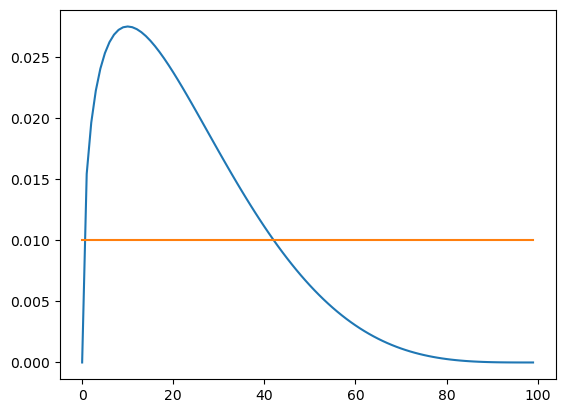

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_vec = np.arange(a,c,1)
vals = [p(x) for x in x_vec]
plt.plot(x_vec, vals)
plt.plot(x_vec, np.ones_like(x_vec) / len(x_vec))

### 1.1

In [4]:
def expected_value_integrand_p(x):
    return p(x) * x

def trapezoidal(fun, x0, xn, n):
    interval = (xn - x0) / n
    integral = 0
    
    x_prev = x0

    for x in np.arange(x0 + interval, xn + interval / 10, interval):
        integral += (x - x_prev)/2 * (fun(x) + fun(x_prev))

        x_prev = x

    return integral

for n in range(1,500):
    diff = np.abs(E - trapezoidal(expected_value_integrand_p, a, c, n)) 
    if diff < 5e-5:
        print(f"Difference between actual E[X] and approximated")
        print("---------------------------------------------------------")
        print(f"E[x] - E_hat[X] = {diff} using {n} samples")
        break

Difference between actual E[X] and approximated
---------------------------------------------------------
E[x] - E_hat[X] = 4.957722734388881e-05 using 271 samples


### 1.2 was done by hand

### 1.3

In [5]:
np.random.seed(42)


for _ in range(10):
    n = 9413605

    estimates = []

    x = np.random.uniform(0,100, size=n)
    fx = 100 * expected_value_integrand_p(x)

    print(f"Average: {np.mean(fx) :.5f}")
    print(f"Std: {np.std(fx) / np.sqrt(n)}")

    # Actual diff
    diff = np.abs(np.mean(fx) - E)
    print(f"Diff: {diff}")

Average: 23.32883
Std: 0.006218402351641426
Diff: 0.004503095774506249
Average: 23.33704
Std: 0.0062189591921063166
Diff: 0.003706061934558136
Average: 23.33190
Std: 0.006217868607202644
Diff: 0.001429876031000532
Average: 23.34266
Std: 0.0062181012237719465
Diff: 0.009329383188394047
Average: 23.32511
Std: 0.006217777475922076
Diff: 0.008219199737659721
Average: 23.33438
Std: 0.006218744849493911
Diff: 0.001049479415573984
Average: 23.33460
Std: 0.006218773351427213
Diff: 0.0012709988174677278
Average: 23.34622
Std: 0.006219525760537308
Diff: 0.012887610715907272
Average: 23.33935
Std: 0.006218308108640831
Diff: 0.006012959370949034
Average: 23.33824
Std: 0.006218719693825996
Diff: 0.0049100018161070125


-0.031087913159705494


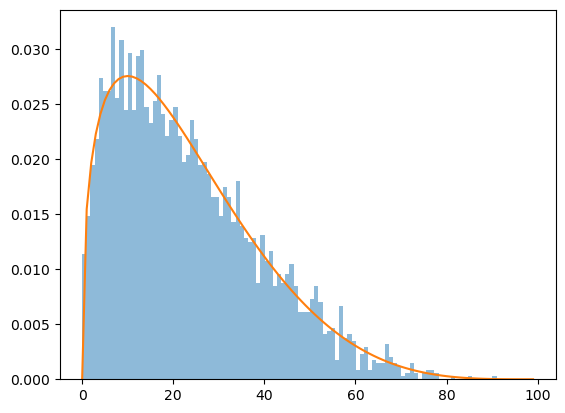

In [6]:
np.random.seed(42)
# Rejection sampling
M = 3
n = 11317

x = np.random.uniform(a,c, size=n)

u = np.random.uniform(0, M * 1 / (c -a), size=n)

# Accept 
accepted = u < p(x)
samples = x[accepted]

print(np.mean(samples) - E)

plt.hist(samples, bins=100, alpha=0.5, label='u samples', density=True)
plt.plot(x_vec, vals)
plt.show()

## Part 2

### 2.1

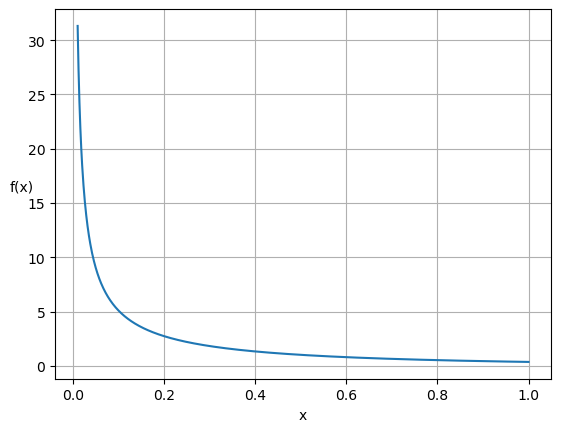

In [7]:
def integrand(x):
    return x**(-3/4) * np.exp(-x)

x = np.linspace(1e-2,1, 1000)
plt.plot(x, integrand(x))
plt.xlabel("x")
plt.ylabel("f(x)", rotation=0)
plt.grid(True)

### 2.2

In [8]:
np.random.seed(42)
n = 10**7

# estimates = []

for _ in range(10):
    x = np.random.uniform(0,1, size=n)
    fx = integrand(x)
    
    print(f"{np.mean(fx)} +/- {np.std(fx) / np.sqrt(n)}")




3.358766787316318 +/- 0.02620844516946836
3.285987749288469 +/- 0.023660974581962632
3.4207903442834726 +/- 0.06634129738738355
3.4831710924054757 +/- 0.10556382554836441
3.3377648062618053 +/- 0.03379518231008055
3.5080304977219203 +/- 0.20198770658959941
3.2544720116910506 +/- 0.016958891963915274
3.4400995683493942 +/- 0.10902066045137224
3.292697900578018 +/- 0.023452572670682733
3.257779094394792 +/- 0.0195474699750726


### 2.3

In [ ]:
def q(x, c = 1/4):
    return c * x**(-3/4)

def q_cdf(x):
    return x**(1/4)

def q_cdf_inv(x):
    return x**4

np.random.seed(42)
n = 10**7
# estimates = []

for _ in range(10):
    u = np.random.uniform(0, 1, size=n)
    x = q_cdf_inv(u)  # samples from q(x)
    fx = integrand(x)
    qx = q(x)
    weights = fx / qx


    print(f"{np.mean(weights)} +/- {np.std(weights) / np.sqrt(n)}")

### 2.4 - maybe make a graph of both with uncertainties

## 3

### 3.1

In [ ]:
def metropolis_hastings(log_posterior, initial, proposal_fn, iterations, data):
    samples = []
    current = np.array(initial)
    current_log_post = log_posterior(current[0], current[1], data)

    for _ in range(iterations):
        proposal = proposal_fn(current)
        proposal_log_post = log_posterior(proposal[0], proposal[1], data)

        accept_ratio = np.exp(proposal_log_post - current_log_post)
        if np.random.rand() < accept_ratio:
            current = proposal
            current_log_post = proposal_log_post
        samples.append(current)

    return np.array(samples)


In [ ]:
def log_posterior(alpha, eta, data):
    if alpha <= 0 or eta <= 0:
        return -np.inf  

    log_likelihood = len(data) * (np.log(alpha) + np.log(eta)) + \
                     (alpha - 1) * np.sum(np.log(data)) - eta * np.sum(data**alpha)

    log_prior = -alpha - 2 * eta + np.log(eta)
    return log_likelihood + log_prior


In [ ]:
def normal_proposal_fn(cov):
    def proposal(current):
        return np.random.multivariate_normal(current, cov)
    return proposal

In [ ]:
def proposal_distr():
    def proposal(current):
        alpha_curr, eta_curr = current
        alpha_new = np.random.exponential(scale=alpha_curr)
        eta_new = np.random.exponential(scale=eta_curr)
        return np.array([alpha_new, eta_new])
    return proposal

In [ ]:
def print_mean_and_var(data, initial, proposal,iterations=10000,burn_in = 1000, cov = None, seed = 42):
    np.random.seed(seed)

    if cov is not None:
        proposal_fn = proposal(cov)

    else:
        proposal_fn = proposal()

    # Run MH
    samples = metropolis_hastings(log_posterior, initial, proposal_fn, iterations, data)

    # Discard burn-in
    samples = samples[burn_in:]

    # Extract α and η
    alpha_samples = samples[:, 0]
    eta_samples = samples[:, 1]

    # Print results
    print(f"Mean of α: {np.mean(alpha_samples):.4f}")
    print(f"Mean of η: {np.mean(eta_samples):.4f}")
    print(f"Variance of α: {np.var(alpha_samples):.4f}")
    print(f"Variance of η: {np.var(eta_samples):.4f}")

In [ ]:
data = np.array([0.3, 0.5, 0.75, 0.4])
initial = [1.0, 1.0]
cov =np.array( [[0.1,0], [0,0.1]])

covariances = [
    np.array([[0.01, 0], [0, 0.01]]),
    np.array([[0.05, 0], [0, 0.05]]),
    np.array([[0.1, 0], [0, 0.1]]),
    np.array([[1.0, 0], [0, 1.0]]),
    np.array([[0.1, 0.05], [0.05, 0.1]]),
    np.array([[0.1, 0.08], [0.08, 0.1]])
]

for cov in covariances:
    print("------------------")
    print("Covariance:\n", cov)
    print_mean_and_var(data, initial, normal_proposal_fn, cov=cov)
    

print("------------------")
print("proposal distribution ")
print_mean_and_var(data, initial, proposal_distr)


------------------
Covariance:
 [[0.01 0.  ]
 [0.   0.01]]
Mean of α: 1.8656
Mean of η: 2.0170
Variance of α: 0.7025
Variance of η: 1.4171
------------------
Covariance:
 [[0.05 0.  ]
 [0.   0.05]]
Mean of α: 1.7843
Mean of η: 1.8494
Variance of α: 0.5317
Variance of η: 0.7712
------------------
Covariance:
 [[0.1 0. ]
 [0.  0.1]]
Mean of α: 1.7852
Mean of η: 1.8572
Variance of α: 0.5071
Variance of η: 0.6067
------------------
Covariance:
 [[1. 0.]
 [0. 1.]]
Mean of α: 1.7685
Mean of η: 1.8386
Variance of α: 0.4383
Variance of η: 0.6380
------------------
Covariance:
 [[0.1  0.05]
 [0.05 0.1 ]]
Mean of α: 1.7367
Mean of η: 1.8429
Variance of α: 0.4696
Variance of η: 0.6684
------------------
Covariance:
 [[0.1  0.08]
 [0.08 0.1 ]]
Mean of α: 1.7398
Mean of η: 1.8739
Variance of α: 0.4504
Variance of η: 0.8049
------------------
proposal distribution 
Mean of α: 1.2284
Mean of η: 1.2432
Variance of α: 0.3300
Variance of η: 0.4106


Mean of α: 1.6862
Mean of η: 1.8227
Variance of α: 0.4334
Variance of η: 0.5419


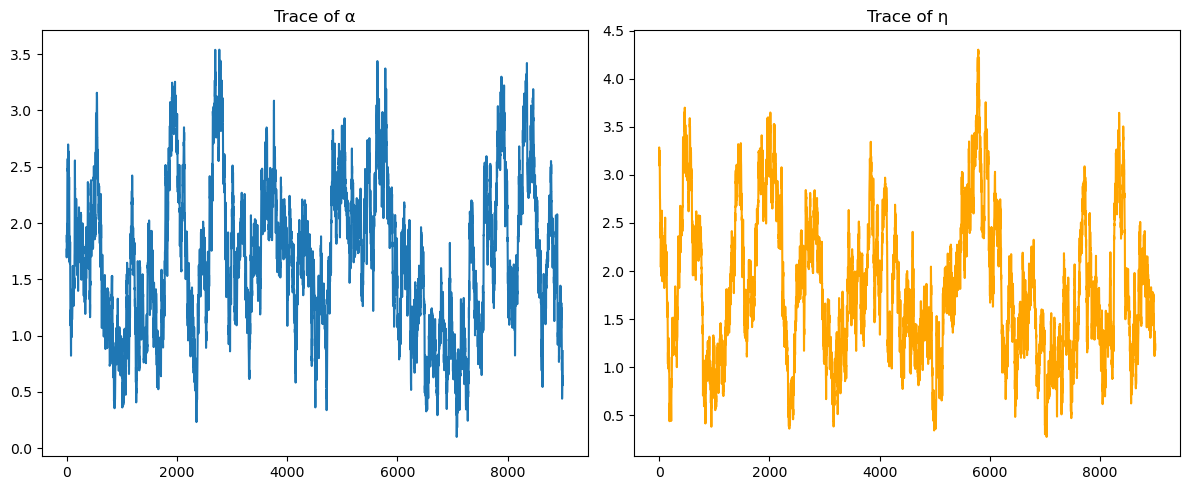

In [ ]:
# Extract α and η samples
alpha_samples = samples[:, 0]
eta_samples = samples[:, 1]

# Results
print(f"Mean of α: {np.mean(alpha_samples):.4f}")
print(f"Mean of η: {np.mean(eta_samples):.4f}")
print(f"Variance of α: {np.var(alpha_samples):.4f}")
print(f"Variance of η: {np.var(eta_samples):.4f}")

# Optional: plot traces
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alpha_samples, label='α')
plt.title("Trace of α")
plt.subplot(1, 2, 2)
plt.plot(eta_samples, label='η', color='orange')
plt.title("Trace of η")
plt.tight_layout()
plt.show()

In [ ]:
def exp_proposal_fn():
    def proposal(current):
        alpha, eta = current
        u1, u2 = np.random.rand(2)
        alpha_new = -alpha * np.log(u1)
        eta_new = -eta * np.log(u2)
        return np.array([alpha_new, eta_new])
    return proposal